#Görev Tanımı
Bu görevde, verilen ahşap yüzey verileri kullanılarak denetimsiz öğrenme (unsupervised learning) yaklaşımıyla bir anomali tespit modeli geliştirilecektir. Model, ahşap yüzeyinde kusurların veya düzensizliklerin tespit edilmesi için eğitilecektir.


#1. Ön İşleme Adımları ve Veri Hazırlığı


In [10]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import os

print("Lütfen JPG dosyalarınızı seçin...")
uploaded_files = files.upload()


Lütfen JPG dosyalarınızı seçin...


Saving 100500011.jpg to 100500011.jpg
Saving 100500053.jpg to 100500053.jpg
Saving 100700037.jpg to 100700037.jpg
Saving 100700054.jpg to 100700054.jpg
Saving 101100012.jpg to 101100012.jpg
Saving 101100013.jpg to 101100013.jpg


###Arka Planı Kaldırma


In [19]:
def crop_and_clean(image):
    # Gri tonlamaya çevir
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Otsu Threshold uygula
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Siyah olmayan alanları bul
    coords = cv2.findNonZero(thresh)

    if coords is not None:
        # En küçük dikdörtgeni belirle ve kırp
        x, y, w, h = cv2.boundingRect(coords)
        cropped_image = image[y:y+h, x:x+w]

        # İkinci kontrol
        gray_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        _, clean_thresh = cv2.threshold(gray_cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Yeniden kırp
        new_coords = cv2.findNonZero(clean_thresh)
        if new_coords is not None:
            x2, y2, w2, h2 = cv2.boundingRect(new_coords)
            cropped_image = cropped_image[y2:y2+h2, x2:x2+w2]

    return cropped_image


###Görüntü Normalizasyonu ve Boyutlandırma

In [20]:
def resize_and_normalize(image, target_size=(256, 256)):
    # Boyutlandırma
    resized_image = cv2.resize(image, target_size)

    # Normalizasyon [0, 1] aralığına
    normalized_image = resized_image / 255.0

    return normalized_image


In [29]:
def process_image(image):
    # 1. Kırpma ve temizleme
    cropped_image = crop_and_clean(image)

    # 2. Boyutlandırma ve normalizasyon
    final_image = resize_and_normalize(cropped_image)


    return final_image


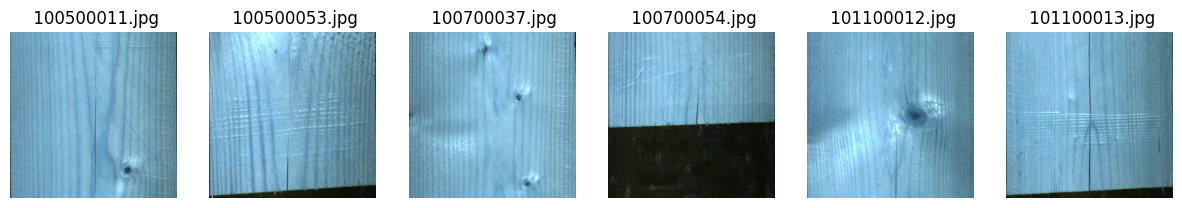

In [30]:
# Resimler üzerinde işlem yapma ve sonucu yan yana gösterme
fig, axes = plt.subplots(1, len(uploaded_files), figsize=(15, 5))

for idx, filename in enumerate(uploaded_files.keys()):
    # Resmi oku
    image = cv2.imread(filename)

    # Resmi işleme
    processed_image = process_image(image)

    # Resmi yan yana göstermek için
    axes[idx].imshow(processed_image)
    axes[idx].axis("off")  # Eksenleri gizle
    axes[idx].set_title(f" {filename}")

plt.show()
